In [1]:
#Importando as bibliotecas que possivelmente seráo usadas
import re
import numpy as np
import pandas as pd
import seaborn as sns
import math
from pprint import pprint
import unicodedata

# Importando a library Natural Language Toolkit - NLTK para tratamento de linguagem natural.
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans


#Importando as stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')# Download das stopworks do NLTK
language = 'portuguese'
stopwords = stopwords.words(language)
stopwords = list(set(stopwords))

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.hdpmodel import HdpModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#Plotagem
import spacy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
from tqdm import tqdm

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\012457631\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\012457631\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\012457631\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
#Importação da base licitação
itens = pd.read_excel('C:/Users/012457631/Documents/Cursos_Resumos/Python/ITENS.xlsx')
#Visualização das colunas da base itens
itens.head(2)

,CD_ORGAO,NR_LICITACAO,ANO_LICITACAO,CD_TIPO_MODALIDADE,NR_ITEM,NR_ITEM_ORIGINAL,DS_ITEM,QT_ITENS,VL_UNITARIO_ESTIMADO,VL_TOTAL_ESTIMADO,DT_REF_VALOR_ESTIMADO,CD_FONTE_REFERENCIA,VL_UNITARIO_HOMOLOGADO,VL_TOTAL_HOMOLOGADO,BL_COVID19
0,44500.0,274.0,2021.0,CPC,1.0,1.0,Credenciamento de academias de ginástica e mus...,100.0,5000.0,5000.0,NaN,NaN,NaN,NaN,N
1,56900.0,25.0,2021.0,TMP,1.0,11.0,PLACA DE OBRA (PARA CONSTRUCAO CIVIL) EM CHAPA...,600.0,27249.0,163494.0,2021-06-18 00:00:00,00004813,NaN,NaN,N


<AxesSubplot:>

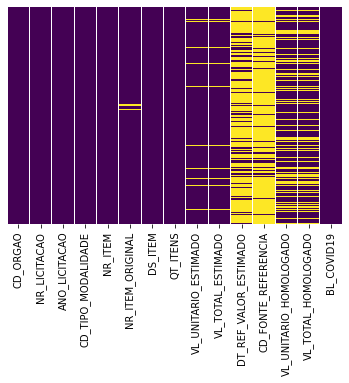

In [5]:
#Verificação de valores vazios
sns.heatmap(itens.isnull(),yticklabels=False,cbar=False,cmap='viridis')

<AxesSubplot:>

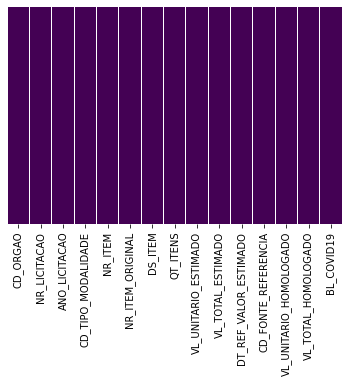

In [6]:
#Retirada dos vazios da base licitação
itens = itens.dropna()
#Verificação de valores vazios
sns.heatmap(itens.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [9]:
#Dados descritivos
itens['VL_TOTAL_HOMOLOGADO'].describe()

count    9.336600e+04
mean     9.766259e+06
std      5.227973e+08
min      0.000000e+00
25%      1.654225e+04
50%      9.349500e+04
75%      4.417015e+05
max      9.180011e+10
Name: VL_TOTAL_HOMOLOGADO, dtype: float64

In [10]:
#Licitaçao de maior valor da base
itens[itens['VL_TOTAL_HOMOLOGADO']== itens['VL_TOTAL_HOMOLOGADO'].max()]
#O maior valor total homologado foi de um serviço de controle de pragas

,CD_ORGAO,NR_LICITACAO,ANO_LICITACAO,CD_TIPO_MODALIDADE,NR_ITEM,NR_ITEM_ORIGINAL,DS_ITEM,QT_ITENS,VL_UNITARIO_ESTIMADO,VL_TOTAL_ESTIMADO,DT_REF_VALOR_ESTIMADO,CD_FONTE_REFERENCIA,VL_UNITARIO_HOMOLOGADO,VL_TOTAL_HOMOLOGADO,BL_COVID19
362243,88225.0,6.0,2021.0,PRE,1.0,1.0,SERVIÇO DE CONTROLE DE PRAGAS,7348500.0,74.0,5437890.0,2021-05-20 00:00:00,COTACAO; 22/2021,1249236.0,9.180011e+10,N


In [11]:
#VL_HOMOLOGADO Total
Total_Homologado = itens['VL_TOTAL_HOMOLOGADO'].sum()
print("A soma dos valores homologados de 2019 a 2021 é",Total_Homologado )

A soma dos valores homologados de 2019 a 2021 é 911836584224.0


In [12]:
#Utilizando StopWords para reduzir e limpar os textos
nlp = spacy.load("pt_core_news_sm") # Uso do core do Spacy

nltk.download('stopwords') # Download das stopworks do NLTK
stopwords = nltk.corpus.stopwords.words('portuguese') # Carregamento das stopwords em português

# Caracteres especiais a serem deletados. Sendo unidades de medida e símbolos especiais que não agregam valor a análise
filter_out = stopwords + ['kg', 'm', 'cm', 'mm', 'mg', 'ml', 'm²', '-', '+', '=', 'mcg', 'nº', 'g', 'ª', 'º','ja','viu','vai','ne','ai','ta','gente','nao','aqui','tambem','vc','voce','entao','ate','agora','ser','sempre','ter','so','porque','sobre','ainda','la','tudo','ninguem','de','do','da','para','pra']

# Função de tratamento
def processing_tokenization(sentence):
    sentence = sentence.lower() # Caixa baixa
    sentence = re.sub(r"[^\w\s]", "",sentence) # Exclusão de caracteres especiais
    sentence = re.sub("[0-9]+","", sentence) # Exclusão de dígitos
    sentence = re.sub("/+","", sentence) # Exclusão de "/"
    sentence = re.sub(' +', ' ', sentence) # Exclusão de espaçamentos repetitivos entre as frases

    doc=nlp(sentence) # Tokenização

    tokens=[token.text for token in doc]
    tokens=[token for token in tokens if token not in filter_out] # Filtragem adicional com os caracteres em filter_out

    return tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\012457631\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# Aplicação do tratamento na lista de licitações e salvando os dados
itens['DS_ITEM_TRATADO'] = itens['DS_ITEM'].apply(lambda x: processing_tokenization(x))
#Passando para a base a coluna tratada
itens.to_csv(('C:/Users/012457631/Documents/Cursos_Resumos/Python/itens_tratados_vf.csv'))

In [22]:
#licitacoes_valores.head(3)

In [14]:
# Aplicando a função na DS_OBJEO, countvectorizer faz a frequencia normal
bow_transformer = CountVectorizer(analyzer=processing_tokenization).fit(itens['DS_ITEM'])
# Mostrando o tamanho do vocabulário
print(len(bow_transformer.vocabulary_))

36564


In [15]:
#Vetorização pela frequencia normal
messages_bow = bow_transformer.transform(itens['DS_ITEM'])

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [06:51<00:00, 27.40s/it]


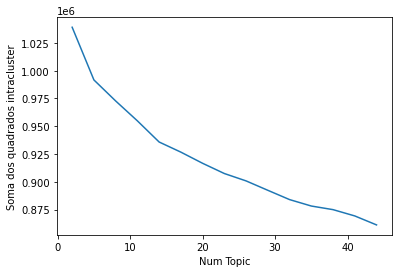

In [16]:
#O primeiro modelo a ser analisado é o Kmeans pois podemos ver a quantidade "razoavel" de clusters graficamente
import warnings
warnings.filterwarnings('ignore')

wcss = []
minimo=2
maximo=45
step=3

for n in tqdm(range(minimo, maximo, step)):
    kmeans_model = KMeans(n_clusters=n, init='k-means++', max_iter=500, n_jobs=-1, algorithm='full', precompute_distances=True)
    kmeans_model.fit(messages_bow)
    wcss.append(kmeans_model.inertia_)

# Show graph
x = range(minimo, maximo, step)

plt.plot(x, wcss)
plt.xlabel("Num Topic")
plt.ylabel("Soma dos quadrados intracluster")
plt.show()

In [17]:
kmeans_model = KMeans(n_clusters=14, init='k-means++', verbose=0, n_jobs=-1, algorithm='full', precompute_distances=True, tol=1e-9, max_iter=500)
X = kmeans_model.fit(messages_bow)
labels=kmeans_model.labels_.tolist()
itens['Topicos_kmeans'] = labels
itens.to_csv(('C:/Users/012457631/Documents/Cursos_Resumos/Python/itens_kmeans_14.csv'))

In [18]:
#Utilizando o modelo LDA para gerar os tópicos
from sklearn.decomposition import LatentDirichletAllocation
LDA = LatentDirichletAllocation(n_components=14,random_state=42)
LDA.fit(messages_bow)

LatentDirichletAllocation(n_components=14, random_state=42)

In [19]:
#Função que retorna as 15 palavras mais importantes por tópico
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([bow_transformer.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['modelo', 'aplicação', 'b', 'condicionado', 'acrílico', 'limpeza', 'selador', 'óleo', 'fundo', 'ano', 'exame', 'motor', 'exames', 'filtro', 'ar']


THE TOP 15 WORDS FOR TOPIC #1
['esmalte', 'cor', 'madeira', 'telha', 'incluso', 'af', 'pintura', 'mão', 'n', 'placa', '_', 'aço', 'galvanizado', 'chapa', 'obra']


THE TOP 15 WORDS FOR TOPIC #2
['reaproveitamento', 'remoção', 'aço', '_', 'af', 'validade', 'data', 'acrílica', 'duas', 'tinta', 'forma', 'aplicação', 'pintura', 'embalagem', 'manual']


THE TOP 15 WORDS FOR TOPIC #3
['convencional', 'bloco', 'concreto', 'estrutura', 'utilizando', 'montagem', 'armação', 'viga', 'ca', 'tipo', 'aço', 'fornecimento', 'instalação', '_', 'af']


THE TOP 15 WORDS FOR TOPIC #4
['fio', 'c', 'antichama', 'fita', 'metros', 'isolado', 'caixa', 'cor', 'flexível', 'tipo', 'mm²', 'cobre', 'v', 'cabo', 'x']


THE TOP 15 WORDS FOR TOPIC #5
['tipo', 'papel', 'litros', 'unidades', 'deve', 'entrega', 'qualidade', 'mínima', 'produto', 

In [20]:
topic_results = LDA.transform(messages_bow)
itens['Topicos_LDA'] = topic_results.argmax(axis=1)
itens.to_csv(('C:/Users/012457631/Documents/Cursos_Resumos/Python/itens_valores_LDA_14.csv'))


In [21]:
#Utilizano o modelo NMF para uma nova separação de tópicos
from sklearn.decomposition import NMF
nmf_model = NMF(n_components=14,random_state=42)
nmf_model.fit(messages_bow)

NMF(n_components=14, random_state=42)

In [22]:
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([bow_transformer.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['xcm', 'xmm', 'técnicafornecimento', 'acessórios', 'técnicaremoção', 'cotação', 'documentação', 'construção', 'reforma', 'especificações', 'demais', 'eou', 'referência', 'conforme', 'termo']


THE TOP 15 WORDS FOR TOPIC #1
['águas', 'nível', 'menor', 'instalado', 'fôrma', 'forma', 'vala', 'escavação', 'solo', 'acabamento', 'incluso', 'madeira', 'manual', 'af', '_']


THE TOP 15 WORDS FOR TOPIC #2
['meiofio', 'trecho', 'reto', 'guia', 'placa', 'medindo', 'inferior', 'largura', 'superior', 'caixa', 'comprimento', 'altura', 'base', 'dimensões', 'x']


THE TOP 15 WORDS FOR TOPIC #3
['prazo', 'contar', 'mínima', 'identificação', 'informações', 'deve', 'fabricação', 'ingredientes', 'peso', 'produto', 'meses', 'entrega', 'data', 'validade', 'embalagem']


THE TOP 15 WORDS FOR TOPIC #4
['junta', 'descarga', 'sanitário', 'serie', 'normal', 'fornecido', 'predial', 'soldável', 'água', 'tubo', 'esgoto', 'instalado', 'ramal', 'dn', 'pvc']


THE TOP 15 WORDS FOR TOPIC 

In [23]:
topic_resultsNMF = nmf_model.transform(messages_bow)
itens['Topicos_NMF'] = topic_resultsNMF.argmax(axis=1)
itens.to_csv(('C:/Users/012457631/Documents/Cursos_Resumos/Python/itens_LDA_NMF_14.csv'))

In [33]:
#licitacoes_valores.head(3)

In [24]:
#Com os 2 modelos salvos na base veremos como ficariam os seus respectivos tópicos utilizando a frequencia inversa TFIDF para vetorização
def identity_tokenizer(text):
    return text
vectorizer = TfidfVectorizer(min_df = 30, lowercase=False, tokenizer=identity_tokenizer)
tfidf = vectorizer.fit_transform(itens['DS_ITEM_TRATADO'])

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:08<00:00,  8.60s/it]


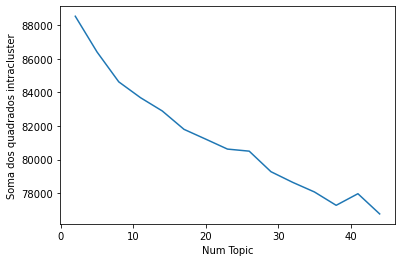

In [25]:
#O primeiro modelo a ser analisado é o Kmeans pois podemos ver a quantidade "razoavel" de clusters graficamente
import warnings
warnings.filterwarnings('ignore')

wcss = []
minimo=2
maximo=45
step=3

for n in tqdm(range(minimo, maximo, step)):
    kmeans_model = KMeans(n_clusters=n, init='k-means++', max_iter=500, n_jobs=-1, algorithm='full', precompute_distances=True)
    kmeans_model.fit(tfidf)
    wcss.append(kmeans_model.inertia_)

# Show graph
x = range(minimo, maximo, step)

plt.plot(x, wcss)
plt.xlabel("Num Topic")
plt.ylabel("Soma dos quadrados intracluster")
plt.show()

In [26]:
kmeans_model = KMeans(n_clusters=16, init='k-means++', verbose=0, n_jobs=-1, algorithm='full', precompute_distances=True, tol=1e-9, max_iter=500)
X = kmeans_model.fit(tfidf)
labels=kmeans_model.labels_.tolist()
itens['Topicos_kmeans'] = labels
itens.to_csv(('C:/Users/012457631/Documents/Cursos_Resumos/Python/itens_kmeans_16.csv'))

In [27]:
#Utilizando o modelo LDA para gerar os tópicos
LDA = LatentDirichletAllocation(n_components=16,random_state=42)
LDA.fit(tfidf)

LatentDirichletAllocation(n_components=16, random_state=42)

In [28]:
#Função que retorna as 15 palavras mais importantes por tópico
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['in', 'loco', 'espessura', 'janela', 'inox', 'porta', 'alumínio', 'concreto', 'cor', 'piso', 'vidro', 'barra', 'idosos', 'abrigo', 'x']


THE TOP 15 WORDS FOR TOPIC #1
['uso', 'pneus', 'mínimo', 'reto', 'base', 'conserto', 'lonas', 'c', 'recapagem', 'guia', 'frasco', 'meiofio', 'r', 'x', 'pneu']


THE TOP 15 WORDS FOR TOPIC #2
['fck', 'categoria', 'solo', 'concretagem', 'bomba', 'bucha', 'uso', 'acabamento', 'jogo', 'vala', 'escavação', 'locação', 'adensamento', 'parafuso', 'lançamento']


THE TOP 15 WORDS FOR TOPIC #3
['interruptor', 'fio', 'antichama', 'x', 'suporte', 'v', 'isolado', 'tomada', 'flexível', 'fornecimento', 'cobre', 'mm²', 'instalação', 'placa', 'cabo']


THE TOP 15 WORDS FOR TOPIC #4
['unidades', 'título', 'letras', 'papel', 'narrativa', 'tamanho', 'companhia', 'ficção', 'obra', 'assunto', 'brochura', 'autor', 'editora', 'capa', 'livro']


THE TOP 15 WORDS FOR TOPIC #5
['af', 'demãos', 'dmt', 'paredes', 'acrílica', 'comprimido', 'basculan

In [29]:
topic_results_tfidf_LDA = LDA.transform(tfidf)
itens['Topicos_tfidf_LDA'] = topic_results_tfidf_LDA.argmax(axis=1)
itens.to_csv(('C:/Users/012457631/Documents/Cursos_Resumos/Python/itens_tfidf_kmeans_LDA_16.csv'))

In [30]:
#Utilizano o modelo NMF para uma nova separação de tópicos
nmf_model = NMF(n_components=16,random_state=42)
nmf_model.fit(tfidf)

NMF(n_components=16, random_state=42)

In [31]:
#Função que retorna as 15 palavras mais importantes por tópico
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['ømm', 'técnicaplaca', 'técnicafornecimento', 'acessórios', 'técnicaremoção', 'construção', 'eou', 'especificações', 'reforma', 'documentação', 'cotação', 'demais', 'conforme', 'referência', 'termo']


THE TOP 15 WORDS FOR TOPIC #1
['junta', 'fornecido', 'graus', 'serie', 'normal', 'predial', 'água', 'joelho', 'ramal', 'instalado', 'soldável', 'tubo', 'esgoto', 'dn', 'pvc']


THE TOP 15 WORDS FOR TOPIC #2
['letrinhas', 'infantil', 'literatura', 'título', 'letras', 'narrativa', 'companhia', 'ficção', 'obra', 'capa', 'assunto', 'autor', 'brochura', 'editora', 'livro']


THE TOP 15 WORDS FOR TOPIC #3
['edificação', 'térrea', 'baldrame', 'sobrado', 'concreto', 'convencional', 'estrutura', 'pilar', 'armado', 'montagem', 'utilizando', 'viga', 'aço', 'ca', 'armação']


THE TOP 15 WORDS FOR TOPIC #4
['profundidade', 'mecanizada', 'remoção', 'cerâmico', 'igual', 'demolição', 'solo', 'menor', 'vala', 'reaproveitamento', 'forma', 'escavação', 'manual', 'af', '_']




In [32]:
topic_results_tfidf_NMF = nmf_model.transform(tfidf)
itens['Topicos_tfidf_NMF'] = topic_results_tfidf_NMF.argmax(axis=1)
itens.to_csv(('C:/Users/012457631/Documents/Cursos_Resumos/Python/itens_tfidf_kmeans_LDA_NMF_16.csv'))

In [43]:
#Inserção das bases para analises
ItensVF = pd.read_excel('C:/Users/012457631/Documents/AnaliseLicitacoes/ItensVS.xlsx')
ItensRenomeados = pd.read_excel('C:/Users/012457631/Documents/AnaliseLicitacoes/Itens_renomeados.xlsx')
BaseItens=pd.merge(ItensVF,ItensRenomeados,how='inner',on='Topicos_kmeans')

In [44]:
#Gerando as culunas de ANO E MES
from datetime import datetime
BaseItens['DT_REF_VALOR_ESTIMADO'] =  pd.to_datetime(BaseItens['DT_REF_VALOR_ESTIMADO'], format='%d/%m/%Y')
BaseItens['ANO'] = BaseItens['DT_REF_VALOR_ESTIMADO'].dt.year
BaseItens['MES'] = BaseItens['DT_REF_VALOR_ESTIMADO'].dt.month

<AxesSubplot:xlabel='MES', ylabel='count'>

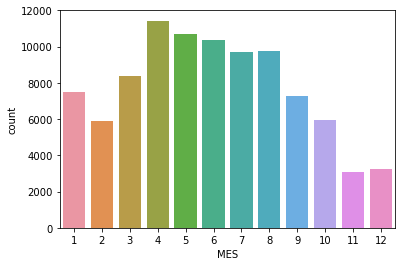

In [45]:
#Gráfico visão geral por mes
sns.countplot(x='MES',data=BaseItens)
#Podemos observar que Abril teve maior quantidade de solicitações

In [56]:
BaseItens.groupby('MES').mean()['VL_TOTAL_HOMOLOGADO'].head(12)
#Agora se tratando de valor monetário (médio), fevereiro foi o mes com maior gasto

MES
1     1.904766e+07
2     5.967160e+08
3     3.359126e+08
4     1.877003e+07
5     1.164182e+08
6     2.254636e+07
7     2.118527e+07
8     2.994339e+07
9     2.712718e+07
10    2.510897e+07
11    1.324639e+07
12    2.186791e+07
Name: VL_TOTAL_HOMOLOGADO, dtype: float64

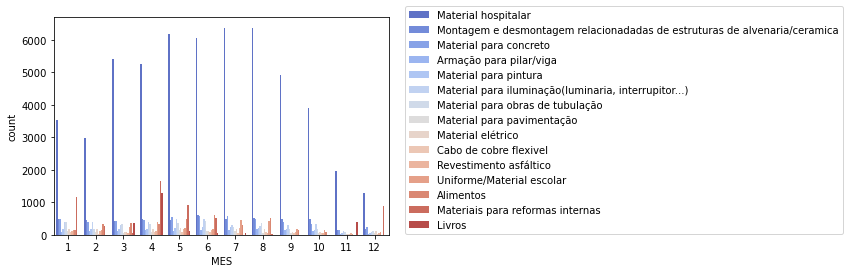

In [54]:
#Gráfico por mes com a segmentação motivo
sns.countplot(x='MES',data=BaseItens,hue='Item',palette='coolwarm')
# To relocate the legend
plt.legend(bbox_to_anchor=(1.05, 1.05), loc=2, borderaxespad=0.)

In [55]:
#Como esperado pelo gráfico acima "Material hospitalar" foi o item mais solicitado, fato também comprovado abaixo
BaseItens['Item'].value_counts().head(16)

Material hospitalar                                                          54221
Materiais para reformas internas                                              5476
Montagem e desmontagem relacionadadas de estruturas de alvenaria/ceramica     5237
Material para concreto                                                        5058
Material para iluminação(luminaria, interrupitor...)                          3821
Alimentos                                                                     3298
Material para obras de tubulação                                              3166
Uniforme/Material escolar                                                     2665
Livros                                                                        2288
Material para pintura                                                         2051
Material elétrico                                                             1614
Armação para pilar/viga                                                       1358
Reve

In [ ]:
#Conclusões Gerais:
#O modelo com melhor tratamento e divisão de dados foi o de bag of word + Kmeans
#Nesse estudo repartimos os dados em 16 clusters com boa diferenciabilidade entre si
#Como esperado a maioria dos itens estão relacionados a obras